# Plánimetria de cauces meandriformes
Motivación: en este notebook indagaremos en el analisis de formas en planta que se generan en cauces meandriformes, se evaluarán señales sencillas (trigonometría básicas [Kinoshita Equation]()) y sobre ellas se determinaran las geometrías asociadas.

In [1]:
# importamos las librerias necesarias
import math 
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pandas as pd
import numpy as np

## Sobre los patrones en planta básicos para cauces meandriformes

### Teoria de ABAD y GARCIA (RCEM 2005)
Ecuaciones de referencia

$$ A= 3.8\left(1+\frac{B}{13.9h}\exp \left(-\frac{13.9h}{B}\right)\right)$$ donde la ecuación de la pendiente de fondo A
$$k_{max}=\frac{\sqrt{2}C_f}{h}\sqrt{A-1+Fr^2}$$
donde representa el parametro geometrico que permite determinar que las máximas velocidades se recuestan sobre la margen externa
$$k_{max}=\frac{2\pi}{\lambda_{min}}$$
### Kinoshita bends
$$\theta =\theta_0\sin\left(\frac{2\pi s}{\lambda}\right)+\theta_0^3\left(J_s\cos \left(3\frac{2\pi s}{\lambda}\right)-J_f\sin\left(3\frac{2\pi s}{\lambda}\right) \right)$$
donde $J_s$ y $J_f$ representa la skewness y flatness y $\theta_0$ es la amplitud angular $\lambda$ y es el arc-wavelength y _s_ es las coordenada streamwise

In [2]:
# Initial data
H = 10 # profundidad media
B = 800 # ancho medio metros
alpha_r = 8.1
Fr0 = 0.1 #número de Froude
D50 = 0.000750 #diametro medio del material de fondo
ks = 2.5*D50 #rugosidad de fondo
C_f = (alpha_r*(H/ks)**(1/6))**(-2)# Rugosidad de Chezzy

In [3]:
#Parametros hidraulicos y gemetrico de cauces aluviales
A =(3.8*(1+B/(13.9*H)*math.exp(-13.9*H/B)))# coeficiente A

kmax = (math.sqrt(2)*C_f)/H*math.sqrt(A-1+Fr0**2) 

lambda_min = (2*math.pi)/kmax #arcwavelength

### Generamos una señal sintetica tipo Kinoshita

In [4]:
# Forma en planta de la curva tipo kinoshita
Ds = 10 #delta de distancia entre puntos
longitud = 150000 #longitud total de la señal en metros
s = list(np.arange(0, longitud, Ds)) #
theta0 = math.radians(45) # theta cero
lambda_ci = 12000
Js = 1/64 #estos parametros se pueden cambiar
Jf = 1/192 #estos parametros se pueden cambiar

#creamos las variables de la misma longitud que s
theta = np.zeros(len(s))
costheta = np.zeros(len(s))
sentheta = np.zeros(len(s))
X =np.zeros(len(s))
Y =np.zeros(len(s))
dist= np.zeros(len(s))
cur =np.zeros(len(s))
n = 0

#implementamos la señal y creamos una 
for i in (s):
    theta[n] = theta0 * math.sin((2*math.pi*i)/lambda_ci)+ theta0**3*(Js*math.cos(3*((2*math.pi*i)/lambda_ci))-Jf*math.sin(3*(2*math.pi*i)/lambda_ci)) 
    costheta[n] = math.cos(theta[n])
    sentheta[n] = math.sin(theta[n])
    if n==0:
        X[n]=0; Y[n]=0
        dist[n] = 0
    else:  
        X[n] = X[n-1] + (s[n]-s[n-1])*costheta[n-1] 
        Y[n] = Y[n-1] + (s[n]-s[n-1])*sentheta[n-1]  
        #determina la curvatura
        cur[n] = (theta[n]-theta[n-1])/Ds
        cur[n] = 0 if np.abs(cur[n]) < 0 else cur[n]
        #calcula distancia
        dist[n] = dist[n-1]+((X[n]-X[n-1])**2+(Y[n]-Y[n-1])**2)**0.5
    
    n+=1
    

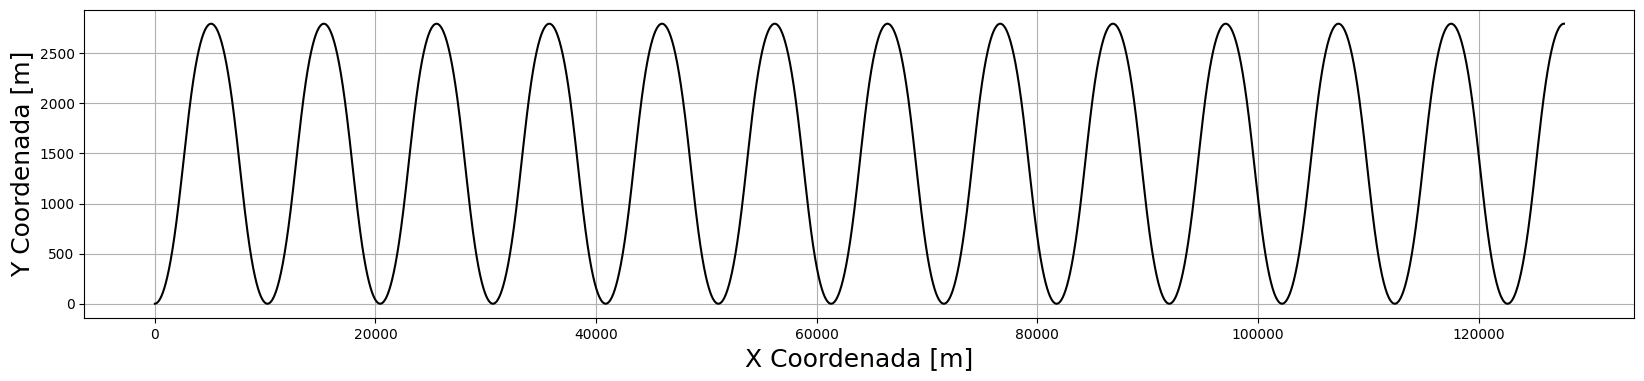

In [5]:
#ploteamos los resultados de Kinoshita
plt.figure(figsize=(20,4))

plt.plot(X, Y,'-k')
plt.xlabel("X Coordenada [m]", size =18)
plt.ylabel("Y Coordenada [m]", size =18)

plt.grid()
plt.show()

In [6]:
import pandas as pd
df = pd.DataFrame({'x':X, 'y':Y})
df.to_csv('kinoshita_arc12000.txt', sep='\t', index=None, header=None)

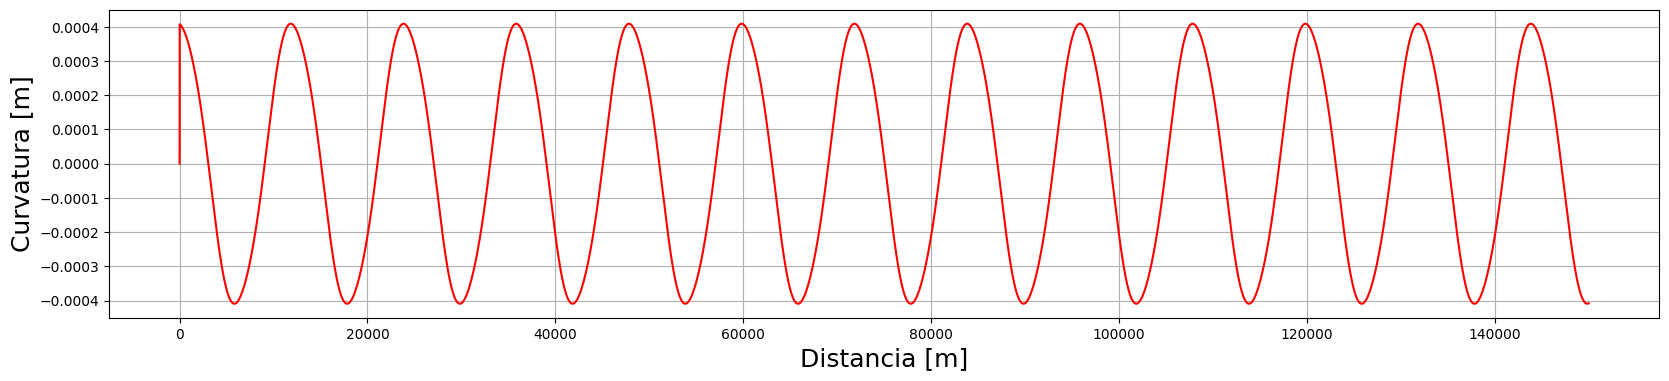

In [7]:
#ploteamos los resultados de Kinoshita
plt.figure(figsize=(20,4))

plt.plot(dist, cur,'-r')

plt.xlabel("Distancia [m]", size =18)
plt.ylabel("Curvatura [m]", size =18)

plt.grid()
plt.show()

! TIP es recomendable hacer un filtrado de la información de linea central esto permite calcular los parametros geometricos. Existen muchos metodos de filtrao uno recomndable es [Savitzky–Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter). A continuación aplicamos este método para la linea generada (en este caso el método sera muy similar a los resultados ya que partimos de una función recreada (una señal sintetica).

In [8]:
#Esta celda usamos cuando tenemos que filtrar información de una linea central 
SMO = 2  # Nivel de suavizado
# Ejecutamos el code
n = SMO if SMO < 39 else int(np.around(1.1**SMO, decimals=0))
xa, xb, ya, yb = X[0], X[-1], Y[0], Y[-1]
for i in range(n):
    x = savgol_filter(X, 5, 2, mode='nearest')
    y = savgol_filter(Y, 5, 2, mode='nearest')
    x[0], x[-1], y[0], y[-1] = xa, xb, ya, yb

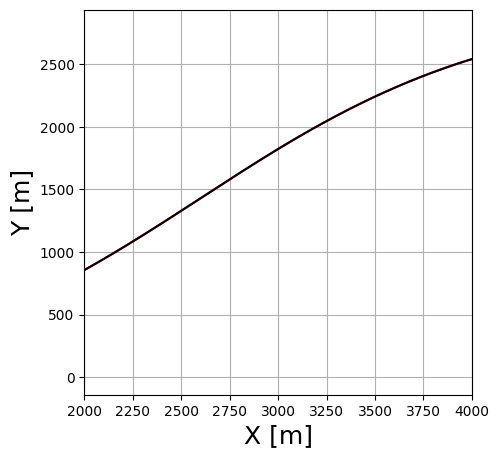

In [9]:
#comparamos la geometría generada y filtrada

plt.figure(figsize=(5,5))

plt.plot(x, y,'-r')
plt.plot(X, Y,'-k')

plt.xlim(2000,4000)
plt.xlabel("X [m]", size =18)
plt.ylabel("Y [m]", size =18)

plt.grid()
plt.show()

numero de curvas= 23
[  305   905  1505  2105  2705  3305  3905  4505  5105  5705  6305  6905
  7505  8105  8705  9305  9905 10505 11105 11705 12305 12905 13505 14105
 14705]


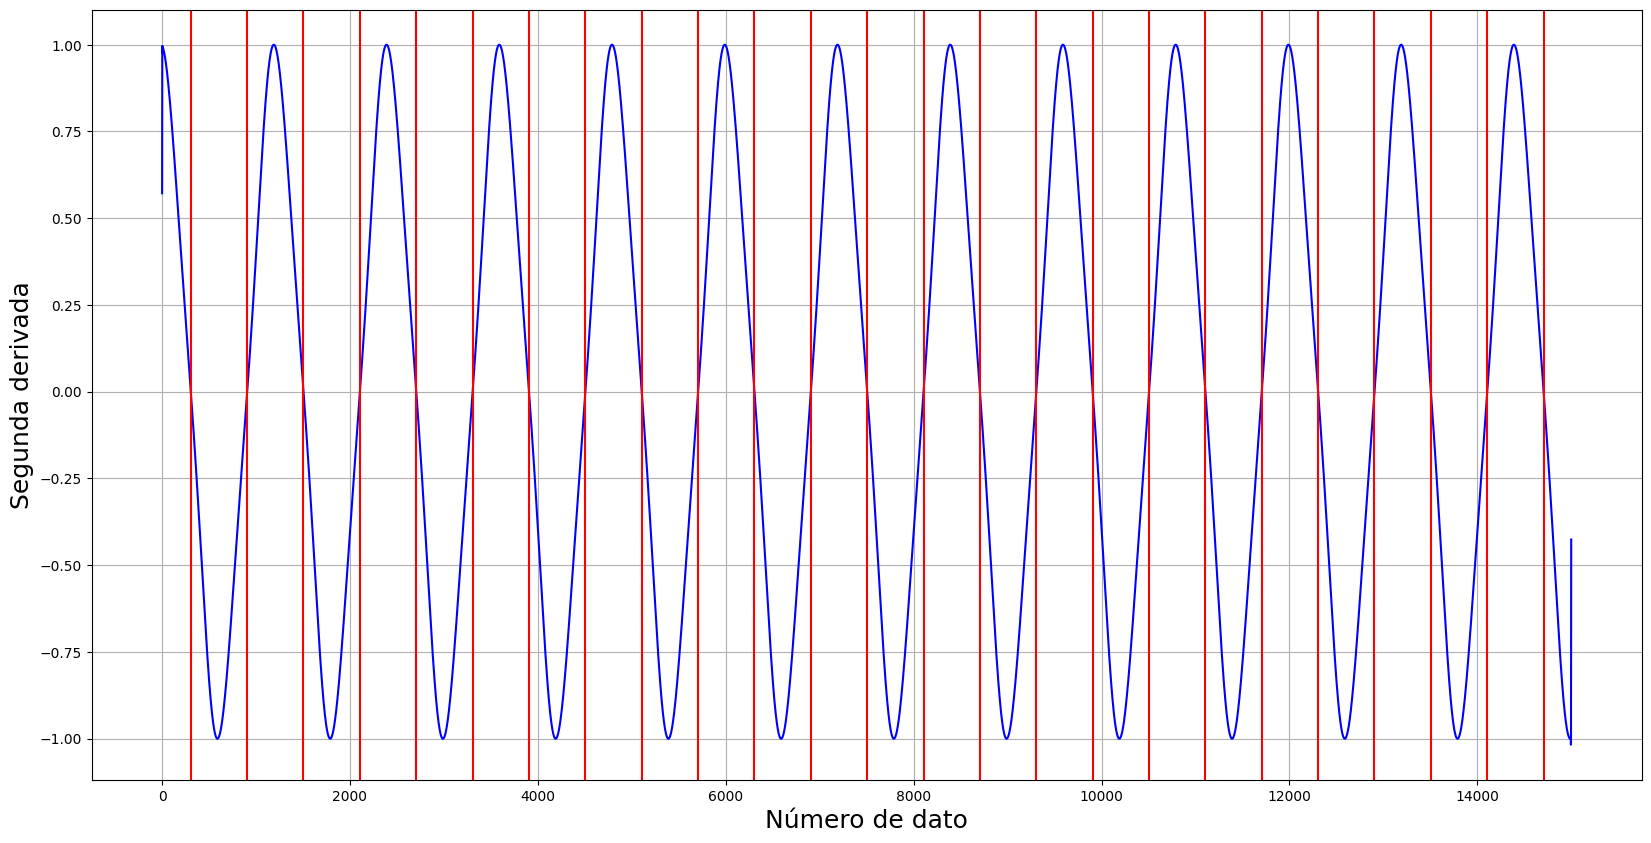

In [10]:
# Determinamos los puntos de inflexión. Determinamos cuantas curvas hay
plt.figure(figsize=(20,10))

# compute second derivative
smooth_d2 = np.gradient(np.gradient(y))

# Este code encuentra los puntos de inflección cuando la segunda derivada es cero
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

# plot results
plt.plot(smooth_d2 / np.max(smooth_d2),'-b')
n = 0

#plt.ylim(-1,1)

#plotemoas la lineas
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='r')
    n = i 

print('numero de curvas=',n-2)
print(infls)

plt.xlabel("Número de dato", size =18)
plt.ylabel("Segunda derivada", size =18)
plt.grid()
plt.show()

In [11]:
# Determinamos los arcwavelength y wavelength 

# Generamos una variable vacía
arc_wavelength = np.zeros(len(infls[1:-1]))
wavelength = np.zeros(len(infls[1:-1]))

#Recorremos la var infls y extremos los puntos donde se dan la condición de inflección
for i, infl in enumerate(infls[1:-1]):
    arc_wavelength[i] = dist[infls[i+1]] - dist[infls[i]]
    wavelength[i] = ((X[infls[i+1]]-X[infls[i]])**2+(Y[infls[i+1]]-Y[infls[i]])**2)**0.5
    
print('longitud de onda=', 2*arc_wavelength)
print('longitud de arco=', 2*wavelength)

longitud de onda= [12000. 12000. 12000. 12000. 12000. 12000. 12000. 12000. 12000. 12000.
 12000. 12000. 12000. 12000. 12000. 12000. 12000. 12000. 12000. 12000.
 12000. 12000. 12000.]
longitud de arco= [10220.37654549 10220.37654549 10220.37654549 10220.37654549
 10220.37654549 10220.37654549 10220.37654549 10220.37654549
 10220.37654549 10220.37654549 10220.37654549 10220.37654549
 10220.37654549 10220.37654549 10220.37654549 10220.37654549
 10220.37654549 10220.37654549 10220.37654549 10220.37654549
 10220.37654549 10220.37654549 10220.37654549]


In [12]:
# Determinamos la sinuosidad
sinuosidad = arc_wavelength / wavelength

print(sinuosidad)

[1.17412504 1.17412504 1.17412504 1.17412504 1.17412504 1.17412504
 1.17412504 1.17412504 1.17412504 1.17412504 1.17412504 1.17412504
 1.17412504 1.17412504 1.17412504 1.17412504 1.17412504 1.17412504
 1.17412504 1.17412504 1.17412504 1.17412504 1.17412504]
